# Arctic Penguin Exploration: Unraveling Clusters in the Icy Domain with K-means clustering

![Alt text](https://imgur.com/orZWHly.png)
source: @allison_horst https://github.com/allisonhorst/penguins

You have been asked to support a team of researchers who have been collecting data about penguins in Antartica! 

**Origin of this data** : Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

**The dataset consists of 5 columns.**

- culmen_length_mm: culmen length (mm)
- culmen_depth_mm: culmen depth (mm)
- flipper_length_mm: flipper length (mm)
- body_mass_g: body mass (g)
- sex: penguin sex

Unfortunately, they have not been able to record the species of penguin, but they know that there are three species that are native to the region: **Adelie**, **Chinstrap**, and **Gentoo**, so your task is to apply your data science skills to help them identify groups in the dataset!

In [1]:
# Import Required Packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Loading and examining the dataset
penguins_df = pd.read_csv("data/penguins.csv")

## Clean the dataset

### Investigate and clean the dataset by removing the null values and outliers.

In [2]:
# removing the null values
penguins_df = penguins_df.dropna()

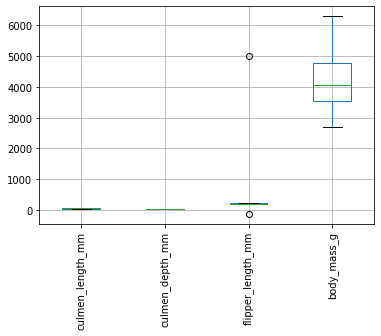

In [3]:
# identify outliers by boxplot visualization 
penguins_df.boxplot()
plt.xticks(rotation=90)
plt.show()

In [4]:
# Calculate the 25th and 75th percentiles
q1 = penguins_df["flipper_length_mm"].quantile(0.25)
q3 = penguins_df["flipper_length_mm"].quantile(0.75)

In [5]:
# Calculate the IQR
IQR = q3 - q1

# Set Multiplying factor, same as default in plt.boxplot() for consistency with the chart
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html
factor = 1.5

In [6]:
# Calculate the lower limit
lower_limit = q1 - (IQR * factor)

# Calculate the upper limit
upper_limit = q3 + (IQR * factor)

In [7]:
# Create a mask for values lower than lower_limit
is_lower = penguins_df["flipper_length_mm"] < lower_limit

# Create a mask for values higher than upper_limit
is_higher = penguins_df["flipper_length_mm"] > upper_limit

# Combine the masks to filter for outliers
outliers = penguins_df[is_lower | is_higher]

# Count and print the number of outliers
print(len(outliers))

2


In [8]:
# removing the outliers and store the cleaned data
penguins_clean = penguins_df.drop(outliers.index)

## Pre-process the cleaned data

### Create the dummy variables and remove the original categorical feature from the dataset.

In [9]:
# Create the dummy variables
penguins_preprocessed = pd.get_dummies(penguins_clean)

penguins_preprocessed

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_.,sex_FEMALE,sex_MALE
0,39.1,18.7,181.0,3750.0,0,0,1
1,39.5,17.4,186.0,3800.0,0,1,0
2,40.3,18.0,195.0,3250.0,0,1,0
4,36.7,19.3,193.0,3450.0,0,1,0
5,39.3,20.6,190.0,3650.0,0,0,1
...,...,...,...,...,...,...,...
338,47.2,13.7,214.0,4925.0,0,1,0
340,46.8,14.3,215.0,4850.0,0,1,0
341,50.4,15.7,222.0,5750.0,0,0,1
342,45.2,14.8,212.0,5200.0,0,1,0


In [10]:
# remove the original categorical feature "sex_." from the dataset
penguins_preprocessed = penguins_preprocessed.drop(["sex_."],axis= 1)

penguins_preprocessed

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_FEMALE,sex_MALE
0,39.1,18.7,181.0,3750.0,0,1
1,39.5,17.4,186.0,3800.0,1,0
2,40.3,18.0,195.0,3250.0,1,0
4,36.7,19.3,193.0,3450.0,1,0
5,39.3,20.6,190.0,3650.0,0,1
...,...,...,...,...,...,...
338,47.2,13.7,214.0,4925.0,1,0
340,46.8,14.3,215.0,4850.0,1,0
341,50.4,15.7,222.0,5750.0,0,1
342,45.2,14.8,212.0,5200.0,1,0


### Scale the data using the standard scaling method

In [11]:
scaler = StandardScaler()

# Scale the data using the standard scaling method
X = scaler.fit_transform(penguins_preprocessed)

# Save the updated data as a new DataFrame
penguins_preprocessed = pd.DataFrame(data=X,columns=penguins_preprocessed.columns)

## Perform Principal Component Analysis (PCA)

In [12]:
# Create a PCA instance: model
pca = PCA()

# Correctly use the instance to call fit
pca.fit(penguins_preprocessed)

transformed = pca.transform(penguins_preprocessed)

Considering any component with an explained variance ratio above 10% as a suitable component

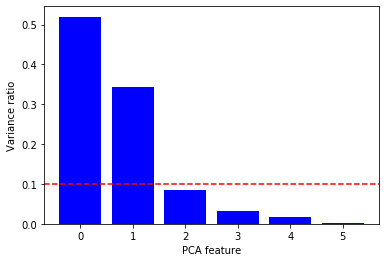

In [13]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color ='b')
plt.axhline(y=0.1, color='r', linestyle='--')
plt.xlabel('PCA feature')
plt.ylabel('Variance ratio')
plt.xticks(features)
plt.show()

In [14]:
n_components=sum(pca.explained_variance_ratio_>0.1)

n_components

2

In [15]:
pca = PCA(n_components=n_components)
penguins_PCA = pca.fit_transform(penguins_preprocessed)

## Employ k-means clustering

### Determine the number of clusters through elbow analysis

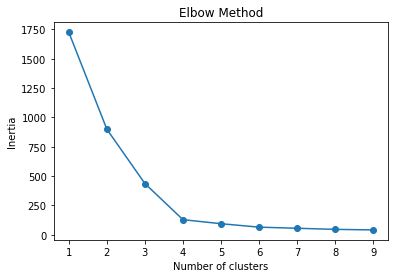

In [16]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(penguins_PCA)
    inertia.append(kmeans.inertia_)    
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [17]:
# Read from the elbow chart number of clusters
n_clusters=4

### Employ k-means clustering

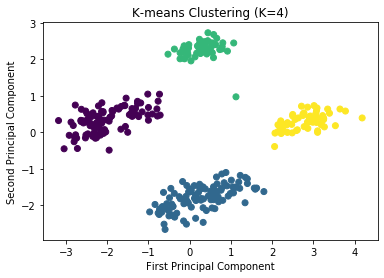

In [22]:
# Create KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(penguins_PCA)

# Visualize clusters using the first two principle components
plt.scatter(penguins_PCA[:, 0], penguins_PCA[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title(f'K-means Clustering (K={n_clusters})')
plt.show()

In [19]:
# Create a statistical table for every penguin species
penguins_clean['label'] = kmeans.labels_
numeric_columns = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm','label']
stat_penguins = penguins_clean[numeric_columns].groupby('label').mean()
stat_penguins

,culmen_length_mm,culmen_depth_mm,flipper_length_mm
label,,,
0,40.217757,17.611215,189.046729
1,43.878302,19.111321,194.764151
2,45.545763,14.262712,212.779661
3,49.473770,15.718033,221.540984
